<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 4: Practical - Convolutional Neural Networks <br>
<font color=696880 size=4>
    Arian Amani
    
    
____


### Full Name : 
### Student Number : 
___

# Problem
This assignment uses PyTorch to build and implement a residual CNN for solving a classification problem. Our goal is to classify handwritten digits from 0 to 9 on the MNIST dataset. You can try larger and more fun datasets if you have access to Google Colab. (for example: [facial emotion detection](https://www.kaggle.com/datasets/msambare/fer2013))

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [232]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################


In [233]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare The Data (10 Points)

Write a composed transformation to transform our dataset's PIL images to tensors and normalize them with ```mean: 0.1307``` and ```std: 0.3081```: 

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html">torchvision.transforms.Compose</a>
</details>

In [234]:
###############################################################
##                Compose your transformations               ##
###############################################################
transformation = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
                ])



Split the downloaded MNIST dataset into two dataloaders ```train``` & ```val```

In [235]:
# Download the MNIST dataset
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

# Number of images in the dataset: 60,000
print(len(mnist_data))

# Split the dataset into training and validation sets
train_data, valid_data = random_split(mnist_data, [50000, 10000]) 

60000


Create dataloaders for your train and validation data with ```batch size 16``` and ```shuffle = True``` for train loader.

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">DATASETS & DATALOADERS</a>
</details>

In [236]:
###############################################################
##           Load the datasets into train/valid              ##
##                       dataloaders                         ##
###############################################################
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=2)
val_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=2)

# Define Model (40 Points)

> Indented block



### You need to implement a model with the architecture below:
[Input: (BS, 1, 28, 28)] -- > [Conv2D (BS, 16, 28, 28)] --> ReLU --> [MaxPool2D (BS, 16, 14, 14): Residual1]

--> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Addition with Residual1]

--> [MaxPool2D (BS, 16, 7, 7)] --> [Conv2D (BS, 64, 7, 7)] --> [ReLU: Residual2]

--> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Addition with Residual2]

--> [GlobalAveragePooling (BS, 64, 1, 1)] --> [Flatten (BS, 64)] --> [Linear (BS, 10)] --> ReLU --> OUT

Here you can see the drawn schematic of the architecture, too: [Link](https://drive.google.com/file/d/1gQzafyxTkuvQr8T-xUncLmedX94LnY_l/view?usp=share_link)

<details>
<summary>Hint</summary>
<br>
These might be helpful:
<br>
<a href="https://pytorch.org/docs/stable/generated/torch.clone.html">TORCH.CLONE</a>
<br><br>
<a href="https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d">AdaptiveAvgPool2d</a> with output size (1, 1) for global average pooling
<br><br>
<a href="https://arxiv.org/pdf/1512.03385.pdf">Deep Residual Learning for Image Recognition</a>
</details>

In [237]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################
class ResidualClassifier(nn.Module):
    def __init__(self):
        super(ResidualClassifier, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 16, kernel_size = 5, stride = 1, padding = 2),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        self.conv2 = nn.Sequential(
                        nn.Conv2d(16, 16, kernel_size = 5, stride = 1, padding = 2),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(16, 16, kernel_size = 5, stride = 1, padding = 2),
                        nn.ReLU(inplace=True))
        self.conv3 = nn.Sequential(
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(16, 64, kernel_size = 5, stride = 1, padding = 2),
                        nn.ReLU(inplace=True))
        self.conv4 = nn.Sequential(
                        nn.Conv2d(64, 64, kernel_size = 5, stride = 1, padding = 2),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(64, 64, kernel_size = 5, stride = 1, padding = 2),
                        nn.ReLU(inplace=True))
        self.conv5 = nn.Sequential(
                        nn.AdaptiveAvgPool2d(1),
                        nn.Flatten(),
                        nn.Linear(64,10))


    def forward(self, x):
        out = self.conv1(x)
        residual1 = out
        out = self.conv2(out)
        out = out + residual1
        out = self.conv3(out)
        residual2 = out
        out = self.conv4(out)
        out = out + residual2
        out = self.conv5(out)

        return out

# Train Model (30 Points)

In [238]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function and etc                                     ##
######################################################################
model = ResidualClassifier().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay = 0.001, momentum = 0.9)  

# optimizer = torch.optim.Adam(model.parameters(),0.001)
criterion = torch.nn.CrossEntropyLoss()


In [239]:
######################################################################
##        Train your model (Complete the code below)                ##
######################################################################
total_step = len(train_loader)
num_epochs = 20
val_loss_lst = []
val_acc_lst = []
train_loss_lst = []
train_acc_lst = []
def test(model, loader, f_loss, device):
    model.eval()
    N = 0
    tot_loss, correct = 0.0, 0.0
    for i, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        N += images.shape[0]
        tot_loss += images.shape[0] * f_loss(outputs, labels).item()
        predicted_labels = outputs.argmax(dim=1)
        correct += (predicted_labels == labels).sum().item()
    return tot_loss/N, correct/N
        
for epoch in range(num_epochs):
    print("Epoch {}".format(epoch))
    for images, labels in train_loader:  
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        val_loss, val_acc = test(model, val_loader, criterion, device)
        train_loss, train_acc = test(model, train_loader, criterion, device)
        val_loss_lst.append(val_loss)
        val_acc_lst.append(val_acc)
        train_loss_lst.append(train_loss)
        train_acc_lst.append(train_acc)
        print(" Training : Loss : {:.4f}, Acc : {:.4f}".format(train_loss, train_acc))
        print(" Validation : Loss : {:.4f}, Acc : {:.4f}".format(val_loss, val_acc))


Epoch 0
 Training : Loss : 0.0741, Acc : 0.9772
 Validation : Loss : 0.0806, Acc : 0.9767
Epoch 1
 Training : Loss : 0.0683, Acc : 0.9792
 Validation : Loss : 0.0767, Acc : 0.9772
Epoch 2
 Training : Loss : 0.0359, Acc : 0.9886
 Validation : Loss : 0.0478, Acc : 0.9852
Epoch 3
 Training : Loss : 0.0347, Acc : 0.9896
 Validation : Loss : 0.0444, Acc : 0.9876
Epoch 4
 Training : Loss : 0.0376, Acc : 0.9878
 Validation : Loss : 0.0506, Acc : 0.9853
Epoch 5
 Training : Loss : 0.0484, Acc : 0.9863
 Validation : Loss : 0.0585, Acc : 0.9830
Epoch 6
 Training : Loss : 0.0301, Acc : 0.9906
 Validation : Loss : 0.0406, Acc : 0.9867
Epoch 7
 Training : Loss : 0.0309, Acc : 0.9909
 Validation : Loss : 0.0434, Acc : 0.9873
Epoch 8
 Training : Loss : 0.0473, Acc : 0.9855
 Validation : Loss : 0.0674, Acc : 0.9822
Epoch 9
 Training : Loss : 0.0286, Acc : 0.9907
 Validation : Loss : 0.0423, Acc : 0.9869
Epoch 10
 Training : Loss : 0.0338, Acc : 0.9894
 Validation : Loss : 0.0448, Acc : 0.9869
Epoch 11


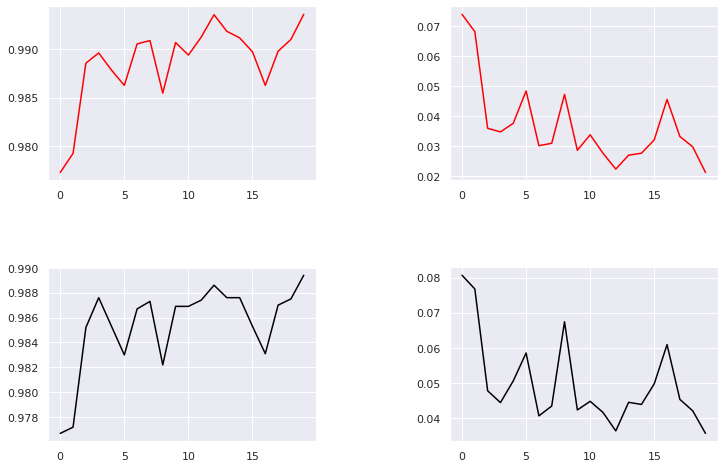

In [240]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################
import seaborn as sn

sn.set()
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

sn.lineplot(data=train_acc_lst, ax=axes[0, 0], color='red');
sn.lineplot(data=train_loss_lst, ax=axes[0, 1], color='red');
sn.lineplot(data=val_acc_lst, ax=axes[1, 0], color='black');
sn.lineplot(data=val_loss_lst, ax=axes[1, 1], color='black');


# Test Model (20 Points)

In [241]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################

test_data = datasets.MNIST(root='data/', download=True, transform=transformation, train=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
print(len(test_data))

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))   

10000
Accuracy of the network on the test images: 99.21 %
